In [16]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate

import xrft.xrft as xrft
import subroutines
import importlib
plt.style.use('latex_default.mplstyle')
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [17]:
compSetting = 'translbq3D_settings' # 'translbq3D_shape' , 'translbq3D_atm'
# compSetting = 'translbq3D_shape' 
# compSetting = 'translbq3D_wind' 
# compSetting = 'translbq3D_atm' 

# folder_path = '/scratch/b/b309199/'
folder_path = '/work/bd0620/b309199/inGrav3D_GWD/'

# fileLocations = ['inGrav3D_005a', 'inGrav3D_006a','inGrav3D_007a','inGrav3D_008a']
# labels=['L: 25km', 'L: 50km', 'L: 75km', 'L: 100km']

# fileLocations = ['inGrav3D_002a', 'inGrav3D_003a','inGrav3D_004a','inGrav3D_005a']
# labels=['L: 2km', 'L: 5km', 'L: 10km', 'L: 25km']

fileLocations = ['inGrav3D_002a', 'inGrav3D_003a','inGrav3D_004a','inGrav3D_005a', 'inGrav3D_006a','inGrav3D_007a','inGrav3D_008a']
labels=['L: 2km', 'L: 5km', 'L: 10km', 'L: 25km', 'L: 50km', 'L: 75km', 'L: 100km']

ds_list = []
for fileLocation in fileLocations:
    fileLocation = folder_path + fileLocation
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv']
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    # ds.attrs['cp']=24.4/2*ds.rg # consistent with simulation
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap

    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    ds['pprime']=ds['p'] # h12
    # ds['pprime']=subroutines.filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)

zfilter:  9.25
0
1
2
3
4
5
6


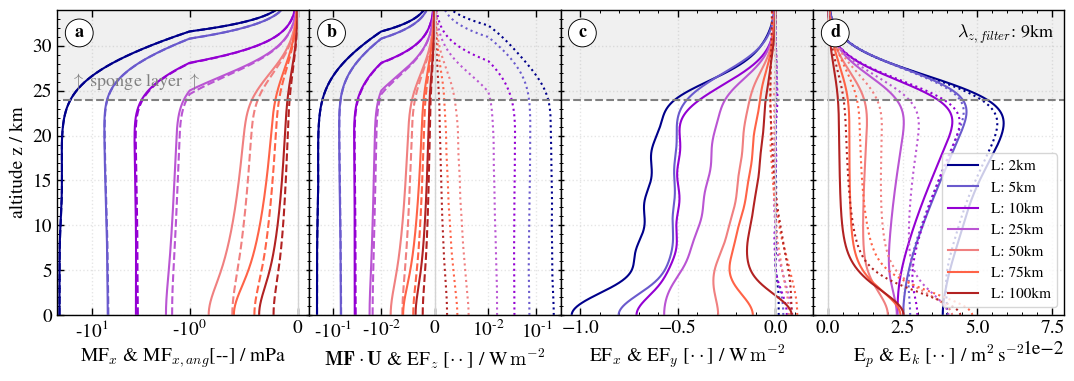

In [18]:
plt.style.use('latex_default_0.mplstyle')
importlib.reload(subroutines)

gskw = {'wspace':0}
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(11,4),sharey=True, gridspec_kw=gskw)

# --- SET TIME, Y AND VERTICAL AEQUIDISTANT GRID --- #
# x=480+53 # t=4 -> 400km (dx=7500m) // 
# x=480 # t=3
# x_range = 20 # -> mean over width of 300km
t=6 # t=3 -> 36h
COLS=['darkblue','slateblue','darkviolet', 'mediumorchid', 'lightcoral','tomato', 'firebrick', 'black']
# COLS=['black', 'blueviolet', 'goldenrod', 'firebrick', 'forestgreen', 'steelblue', 'olive', 'peru']
ZLIM = [0,34]

# --- INDEXES FOR VERTICAL AND HORIZONTAL AVERAGE --- #
wind_f = 15 # m/s
# nx_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dx00)+1
# nz_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dz00)+1
# nx_avg = int(2*np.pi*wind_f/ds.bv/ds.dx00)+1
# nz_avg = int(2*np.pi*wind_f/ds.bv/ds.dz00)+1
nz_avg = 185 # *0.05km -> 7.5km
# nz_avg = 210 # *0.05km -> 7.5km
# nz_avg = 130 # *0.05km -> 7.5km
print('zfilter: ', nz_avg*ds.dz00/1000)

i=0
for ds_temp in ds_list:
    ds = ds_temp.copy()
    print(i)
    y=int(ds.ny/2)
    z = np.linspace(0,ds['zcr'][t,-1,y,0].values,int(ds.nz)) # ds['dx']=200
    
    # - Coriolis and dthdz for angular momentum flux calculation - #
    f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
    
    z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
    the = ds['the'][t,:,y,:]
    the = the.assign_coords(z_coord = ("z",z_coord))
    dthdz = the.differentiate("z_coord")
    
    # --------- Calculate fluxes -------------------- # 
    uw   = ds['w'][t,:,y,:] * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])
    vw   = ds['w'][t,:,y,:] * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:])
    mfx  = ds['rh0'][t,:,y,:] * uw # h9=h3*h6
    mfx_ang = ds['rh0'][t,:,y,:] * (uw - f * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz) ###########
    mfy  = ds['rh0'][t,:,y,:] * vw
    mfy_ang = ds['rh0'][t,:,y,:] * (vw + f * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz)
    MF_U = mfx * ds['u'][t,:,y,:] + mfy * ds['v'][t,:,y,:] # = -EFz
    MF_U_ang = mfx_ang * ds['u'][t,:,y,:] + mfy_ang * ds['v'][t,:,y,:]
    u2   = (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])**2
    v2   = ds['v'][t,:,y,:]**2
    w2   = ds['w'][t,:,y,:]**2
    
    efx = (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['pprime'][t,:,y,:] # h14, EFx1
    efy = (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['pprime'][t,:,y,:]
    # efx = np.sqrt(efx**2+efy**2)
    efz = ds['w'][t,:,y,:] * ds['pprime'][t,:,y,:] # h13, EFz1

    # -- TEMPERATURE CALCULATION -- #                             
    thloc = ds['the'][t,:,y,:] + ds['th'][t,:,y,:] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,:,y,:]*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T_env
    # tte = ds['the'][t,:,y,:]*(ds['ppe'][t,:,y,:]/ds['pref00'])**(2/24.4) # T_env
    tloc = thloc*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte
    
    ek = 1/2*(u2+v2+w2)
    ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'][t,:,y,:] #  potential energy density
    # --------- Calculate fluxes -------------------- # 
    
    # --- INTERPOLATE TO AEQUIDISTANT GRID FOR FILTER ----- #
    rho  = subroutines.interp_elev_to_z(ds['rh0'][t,:,y,:],ds.zcr[t,:,y,:],z)
    u    = subroutines.interp_elev_to_z(ds['u'][t,:,y,:],ds.zcr[t,:,y,:],z)
    v    = subroutines.interp_elev_to_z(ds['v'][t,:,y,:],ds.zcr[t,:,y,:],z)
    th   = subroutines.interp_elev_to_z(ds['th'][t,:,y,:],ds.zcr[t,:,y,:],z)
    uw   = subroutines.interp_elev_to_z(uw,ds.zcr[t,:,y,:],z)
    vw   = subroutines.interp_elev_to_z(vw,ds.zcr[t,:,y,:],z)
    mfx  = subroutines.interp_elev_to_z(mfx,ds.zcr[t,:,y,:],z)
    mfx_ang  = subroutines.interp_elev_to_z(mfx_ang,ds.zcr[t,:,y,:],z)
    mfy  = subroutines.interp_elev_to_z(mfy,ds.zcr[t,:,y,:],z)
    mfy_ang  = subroutines.interp_elev_to_z(mfy_ang,ds.zcr[t,:,y,:],z)
    efx  = subroutines.interp_elev_to_z(efx,ds.zcr[t,:,y,:],z)
    efy  = subroutines.interp_elev_to_z(efy,ds.zcr[t,:,y,:],z)
    efz  = subroutines.interp_elev_to_z(efz,ds.zcr[t,:,y,:],z)
    ep   = subroutines.interp_elev_to_z(ep,ds.zcr[t,:,y,:],z)
    MF_U = subroutines.interp_elev_to_z(MF_U,ds.zcr[t,:,y,:],z)
    MF_U_ang = subroutines.interp_elev_to_z(MF_U_ang,ds.zcr[t,:,y,:],z)
    ek   = subroutines.interp_elev_to_z(ek,ds.zcr[t,:,y,:],z)
    
    # --- FFT OR RUNNING MEAN FILTER ------ #
    mm = 1
    # --- 2D filter --- # 
    # uw=filter_2D(uw,nx_avg,nz_avg,mode=mm)
    # mfx=filter_2D(mfx,nx_avg,nz_avg,mode=mm)
    # ep=filter_2D(ep,nx_avg,nz_avg,mode=mm)
    
    # --- 1D filter --- #
    # rho = subroutines.filter_1Dz(rho,nz_avg,mode=mm)
    # uw  = subroutines.filter_1Dz(uw,nz_avg,mode=mm)
    # vw  = subroutines.filter_1Dz(vw,nz_avg,mode=mm)
    # mfx = subroutines.filter_1Dz(mfx,nz_avg,mode=mm)
    # mfx_ang = subroutines.filter_1Dz(mfx_ang,nz_avg,mode=mm)
    # mfy = subroutines.filter_1Dz(mfy,nz_avg,mode=mm)
    # mfy_ang = subroutines.filter_1Dz(mfy_ang,nz_avg,mode=mm)
    # ep  = subroutines.filter_1Dz(ep,nz_avg,mode=mm)
    # efx = subroutines.filter_1Dz(efx,nz_avg,mode=mm)
    # efy = subroutines.filter_1Dz(efy,nz_avg,mode=mm)
    # efz = subroutines.filter_1Dz(efz,nz_avg,mode=mm)
    # MF_U = subroutines.filter_1Dz(MF_U,nz_avg,mode=mm)
    # MF_U_ang = subroutines.filter_1Dz(MF_U_ang,nz_avg,mode=mm)
    # ek  = subroutines.filter_1Dz(ek,nz_avg,mode=mm)
    
    # - Calc fluxes after interpolations - #
    # mfx_ang = rho * (uw - f * v * th / dthdz)
    # mfy_ang = rho * (vw + f * u * th / dthdz)
    MF_U_ang = mfx_ang*10 + mfy_ang*0
    MF_U = mfx*10 + mfy_ang*0
    
    # --- Horizontal average / horizontal integration of fluxes --- #
    if ds.irelx: # sponge layer left/right active 
        n_sponge=int(ds.dxabL/ds.dx00)
    else: # cyclic boundaries
        n_sponge=0
        
    # -> horizontal mean
    # uw_m = uw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    # vw_m = vw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfx_m = mfx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfx_ang_m = mfx_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    # mfy_m = mfy[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    # mfy_ang_m = mfy_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    ep_m = ep[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    ek_m = ek[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efx_m = efx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efy_m = efy[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efz_m = efz[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_m = MF_U[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_ang_m = MF_U_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    
     # --- 1D filter --- #
    # rho = subroutines.filter_1Dz(rho_m,nz_avg,mode=mm)
    # uw  = subroutines.filter_1Dz(uw_m,nz_avg,mode=mm)
    # vw  = subroutines.filter_1Dz(vw_m,nz_avg,mode=mm)
    mfx_m = subroutines.filter_1Dz(mfx_m,nz_avg,mode=mm)
    mfx_ang_m = subroutines.filter_1Dz(mfx_ang_m,nz_avg,mode=mm)
    # mfy_m = subroutines.filter_1Dz(mfy_m,nz_avg,mode=mm)
    # mfy_ang_m = subroutines.filter_1Dz(mfy_ang_m,nz_avg,mode=mm)
    ep_m  = subroutines.filter_1Dz(ep_m,nz_avg,mode=mm)
    efx_m = subroutines.filter_1Dz(efx_m,nz_avg,mode=mm)
    efy_m = subroutines.filter_1Dz(efy_m,nz_avg,mode=mm)
    efz_m = subroutines.filter_1Dz(efz_m,nz_avg,mode=mm)
    MF_U_m = subroutines.filter_1Dz(MF_U_m,nz_avg,mode=mm)
    MF_U_ang_m = subroutines.filter_1Dz(MF_U_ang_m,nz_avg,mode=mm)
    ek_m  = subroutines.filter_1Dz(ek_m,nz_avg,mode=mm)
    
    # -- VISUALIZATION -- #
    lw = 1.5
    ax0.plot(1000*mfx_m, z, lw=lw, color=COLS[i], label=labels[i])
    ax0.plot(1000*mfx_ang_m, z, lw=lw, ls='dashed', color=COLS[i], label=labels[i])
    ax1.plot(efz_m, z, lw=lw, label=labels[i], ls='dotted', color=COLS[i])
    ax1.plot(MF_U_m, z, lw=lw, color=COLS[i])
    ax1.plot(MF_U_ang_m, z, lw=lw, ls='dashed', color=COLS[i])
    ax2.plot(efx_m, z, lw=lw, color=COLS[i])
    ax2.plot(efy_m, z, lw=lw, ls='dotted', color=COLS[i])
    ax3.plot(ep_m, z, lw=lw, label=labels[i], color=COLS[i])
    ax3.plot(ek_m, z, lw=lw, ls='dotted', color=COLS[i])
    
    i+=1
    
# -- FORMAT AXES -- #
ax0.set_xlabel('MF$_x$ & MF$_{x,ang}$[--] / mPa')
ax1.set_xlabel(r"$\mathbf{MF} \cdot \mathbf{U}$ & EF$_z$ [$\cdot \cdot$] / W$ \, \mathrm{m}^{-2}$")
# ax1.set_xlabel(r"$\vec{MF} \cdot \vec{U}$ & EF$_z$ [$\cdot \cdot$] / W m$^{-2}$")
# ax2.set_xlabel(r"EF$_x$ / W$ \, \mathrm{m}^{-2}$")
ax2.set_xlabel(r"EF$_x$ & EF$_y$ [$\cdot \cdot$] / W$ \, \mathrm{m}^{-2}$")
# ax3.set_xlabel('E$_P$ / J kg$^{-1}$')
ax3.set_xlabel('E$_p$ & E$_k$ [$\cdot \cdot$] / m$^2 \,$s$^{-2}$')

ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(axis="y", which='both', right=False)
ax1.tick_params(axis="y", which='both', direction="inout", right=False)
ax2.tick_params(axis="y", which='both', direction="inout", right=False)
ax3.tick_params(axis="y", which='both', direction="inout", right=False)

# - SPONGE LAYER - #
lw_sponge = 1.5
hsponge = 24
ax0.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')
ax1.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')
ax2.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')
ax3.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')

sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
ax0.text(0.05, 0.75, sponge_label, transform=ax0.transAxes, color='grey')

c3 = 'lightgrey'
htop = 34
alpha_sponge = 0.33
# axes[i,j].axhline(y=48, lw=1.5,ls='--',color='grey')
ax0.fill_between(ax0.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax1.fill_between(ax1.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax2.fill_between(ax2.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax3.fill_between(ax3.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)


symb_ax = '-'
col_ax = 'lightgrey'
lw_ax = 1
ax0.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)
ax1.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)
ax2.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)
ax3.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)

ax0.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)
ax1.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)
ax2.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)
ax3.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)

# --- Labels and legend --- #
ax3.legend(loc='lower right', fontsize=11) # 'upper left'
# ax5.axis('off')

ax0.set_ylim(ZLIM)
ax0.set_ylabel(r'altitude z / km')

# --- Limits and Sci format --- #
ax0.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax2.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))

"""
ax0.set_xlim([-2,0.1]) # MFx
ax1.set_xlim([-0.025,0.025]) # EFz
ax2.set_xlim([-0.6,0.2]) # EFx
ax3.set_xlim([-0.001,0.04]) # Ep
ax4.set_xlim([-5,110])
"""

ax0.set_xlim([-23,0.1]) # MFx
ax1.set_xlim([-0.27,0.27]) # EFz
ax1.set_xlim([-0.32,0.32]) # EFz
ax2.set_xlim([-1.1,0.19]) # EFx
ax3.set_xlim([-0.005,0.079]) # Ep
ax1.set_xscale('symlog', linthresh=0.01)
ax0.set_xscale('symlog', linthresh=1)
# ax1.set_xlim([-0.25,0.25]) # EFz

ax0.grid(visible=True)
ax1.grid(visible=True)
ax2.grid(visible=True)
ax3.grid(visible=True)

# --- Text --- #
ax0.text(0.07, 0.91, 'a', transform=ax0.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax1.text(0.07, 0.91, 'b', transform=ax1.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax2.text(0.07, 0.91, 'c', transform=ax2.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax3.text(0.07, 0.91, 'd', transform=ax3.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

time_label = 'T' + str(t*12) + 'h'

fig_title = 'MWs-zprofiles_all.png'

# ax0.text(0.05, 0.94, time_label, transform=ax0.transAxes, weight='bold')

filter_label = '$\lambda_{z,filter}$: ' + str(int(round(nz_avg*ds.dz00/1000))) + 'km'
ax3.text(0.575, 0.91, filter_label, transform=ax3.transAxes)

# --- Save figure --- #
# fig.suptitle(title_label)
fig.tight_layout()
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=300, bbox_inches='tight')

zfilter:  9.45
0
1
2
3
4
5
6


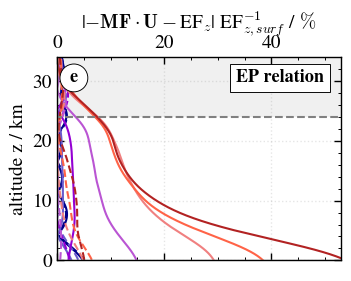

In [13]:
gskw = {'wspace':0}
fig, (ax0) = plt.subplots(1,1,figsize=(3.7,3),sharey=True, gridspec_kw=gskw)

# --- SET TIME, Y AND VERTICAL AEQUIDISTANT GRID --- #
# x=480+53 # t=4 -> 400km (dx=7500m) // 
# x=480 # t=3
# x_range = 20 # -> mean over width of 300km
t=5 # t=3 -> 36h
COLS=['darkblue','slateblue','darkviolet', 'mediumorchid', 'lightcoral','tomato', 'firebrick', 'black']
# COLS=['black', 'blueviolet', 'goldenrod', 'firebrick', 'forestgreen', 'steelblue', 'olive', 'peru']
ZLIM = [0,34]

# --- INDEXES FOR VERTICAL AND HORIZONTAL AVERAGE --- #
wind_f = 15 # m/s
# nx_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dx00)+1
# nz_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dz00)+1
# nx_avg = int(2*np.pi*wind_f/ds.bv/ds.dx00)+1
nz_avg = int(2*np.pi*wind_f/ds.bv/ds.dz00)+1
# nz_avg = 40 # *0.25km -> 10km
print('zfilter: ', nz_avg*ds.dz00/1000)

i=0
for ds_temp in ds_list:
    ds = ds_temp.copy()
    print(i)
    y=int(ds.ny/2)
    z = np.linspace(0,ds['zcr'][t,-1,y,0].values,int(ds.nz)) # ds['dx']=200
    
    # - Coriolis and dthdz for angular momentum flux calculation - #
    f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
    
    z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
    the = ds['the'][t,:,y,:]
    the = the.assign_coords(z_coord = ("z",z_coord))
    dthdz = the.differentiate("z_coord")
    
    # --------- Calculate fluxes -------------------- # 
    uw   = ds['w'][t,:,y,:] * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])
    vw   = ds['w'][t,:,y,:] * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:])
    mfx  = ds['rh0'][t,:,y,:] * uw # h9=h3*h6
    mfx_ang = ds['rh0'][t,:,y,:] * (uw - f * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz) ###########
    mfy  = ds['rh0'][t,:,y,:] * vw
    mfy_ang = ds['rh0'][t,:,y,:] * (vw + f * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz)
    MF_U = mfx * ds['u'][t,:,y,:] + mfy * ds['v'][t,:,y,:] # = -EFz
    MF_U_ang = mfx_ang * ds['u'][t,:,y,:] + mfy_ang * ds['v'][t,:,y,:]
    
    efx = (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['pprime'][t,:,y,:] # h14, EFx1
    efz = ds['w'][t,:,y,:] * ds['pprime'][t,:,y,:] # h13, EFz1

    # -- TEMPERATURE CALCULATION -- #                             
    thloc = ds['the'][t,:,y,:] + ds['th'][t,:,y,:] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,:,y,:]*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T_env
    tloc = thloc*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte

    ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'][t,:,y,:] #  potential energy density
    # --------- Calculate fluxes -------------------- # 
    
    # --- INTERPOLATE TO AEQUIDISTANT GRID FOR FILTER ----- #
    rho  = subroutines.interp_elev_to_z(ds['rh0'][t,:,y,:],ds.zcr[t,:,y,:],z)
    u    = subroutines.interp_elev_to_z(ds['u'][t,:,y,:],ds.zcr[t,:,y,:],z)
    v    = subroutines.interp_elev_to_z(ds['v'][t,:,y,:],ds.zcr[t,:,y,:],z)
    th   = subroutines.interp_elev_to_z(ds['th'][t,:,y,:],ds.zcr[t,:,y,:],z)
    uw   = subroutines.interp_elev_to_z(uw,ds.zcr[t,:,y,:],z)
    vw   = subroutines.interp_elev_to_z(vw,ds.zcr[t,:,y,:],z)
    mfx  = subroutines.interp_elev_to_z(mfx,ds.zcr[t,:,y,:],z)
    mfx_ang  = subroutines.interp_elev_to_z(mfx_ang,ds.zcr[t,:,y,:],z)
    mfy  = subroutines.interp_elev_to_z(mfy,ds.zcr[t,:,y,:],z)
    efx  = subroutines.interp_elev_to_z(efx,ds.zcr[t,:,y,:],z)
    efz  = subroutines.interp_elev_to_z(efz,ds.zcr[t,:,y,:],z)
    ep   = subroutines.interp_elev_to_z(ep,ds.zcr[t,:,y,:],z)
    MF_U = subroutines.interp_elev_to_z(MF_U,ds.zcr[t,:,y,:],z)
    MF_U_ang = subroutines.interp_elev_to_z(MF_U_ang,ds.zcr[t,:,y,:],z)
    
    # --- FFT OR RUNNING MEAN FILTER ------ #
    mm = 1
    # --- 2D filter --- # 
    # uw=filter_2D(uw,nx_avg,nz_avg,mode=mm)
    # mfx=filter_2D(mfx,nx_avg,nz_avg,mode=mm)
    # ep=filter_2D(ep,nx_avg,nz_avg,mode=mm)
    
    # --- 1D filter --- #
    rho = subroutines.filter_1Dz(rho,nz_avg,mode=mm)
    uw  = subroutines.filter_1Dz(uw,nz_avg,mode=mm)
    vw  = subroutines.filter_1Dz(vw,nz_avg,mode=mm)
    mfx = subroutines.filter_1Dz(mfx,nz_avg,mode=mm)
    mfx_ang = subroutines.filter_1Dz(mfx_ang,nz_avg,mode=mm)
    mfy = subroutines.filter_1Dz(mfy,nz_avg,mode=mm)
    ep  = subroutines.filter_1Dz(ep,nz_avg,mode=mm)
    efx = subroutines.filter_1Dz(efx,nz_avg,mode=mm)
    efz = subroutines.filter_1Dz(efz,nz_avg,mode=mm)
    MF_U = subroutines.filter_1Dz(MF_U,nz_avg,mode=mm)
    MF_U_ang = subroutines.filter_1Dz(MF_U_ang,nz_avg,mode=mm)
    
    # - Calc fluxes after interpolations and filtering - #
    # mfx_ang = rho * (uw - f * v * th / dthdz)
    # mfy_ang = rho * (vw + f * u * th / dthdz)
    MF_U_ang = mfx_ang*10 + mfy_ang*0
    MF_U = mfx*10
    
    # --- Horizontal average / horizontal integration of fluxes --- #
    if ds.irelx: # sponge layer left/right active 
        n_sponge=int(ds.dxabL/ds.dx00)
    else: # cyclic boundaries
        n_sponge=0
    
    # -> horizontal mean
    uw_m = uw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    vw_m = vw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfx_m = mfx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfx_ang_m = mfx_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfy_m = mfy[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    ep_m = ep[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efx_m = efx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efz_m = efz[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_m = MF_U[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_ang_m = MF_U_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    
    delta_ep = (-efz_m-MF_U_m)/efz_m[0]*100
    delta_ep_ang = (-efz_m-MF_U_ang_m)/efz_m[0]*100
    # delta_ep = subroutines.filter_1Dz(delta_ep,nz_avg,mode=0)

    def vertical_filter_for_ep_diff(data):
        ## REPLACE NANs AND PAD ##
        data = data.ffill(dim='z').bfill(dim='z')
        data = data.pad(z=nz_avg, mode="edge")
        # data = data.pad(x=nx_avg, mode="edge")

        ## FFT ##
        data=data.drop(['z','z_coord'],errors='ignore')
        da_fft = xrft.fft(data) # Fourier Transform w/ numpy.fft-like behavior   
        # da_fft = xrft.dft(data, true_phase=True, true_amplitude=True)

        ## GAUSSIAN RESPONSE FUNCTION ##
        response_func_z = np.exp(-da_fft.freq_z**2 * nz_avg**2)
        da_fft_low = da_fft * response_func_z

        ## INVERSE FFT ##
        data_filtered = xrft.ifft(da_fft_low)[nz_avg:ds.nz+nz_avg]
        return data_filtered
    
    delta_ep = vertical_filter_for_ep_diff(delta_ep)
    delta_ep_ang = vertical_filter_for_ep_diff(delta_ep_ang)
    
    # -- VISUALIZATION -- #
    lw=1.5
    ax0.plot(abs(delta_ep[2:]), z[2:], lw=lw, label=labels[i], color=COLS[i]) # subtract absolute values!!!
    ax0.plot(abs(delta_ep_ang[2:]), z[2:], lw=lw, ls='dashed', color=COLS[i])
    
    i+=1
    
# -- FORMAT AXES -- #
ax0.set_xlabel(r"|$-\mathbf{MF} \cdot \mathbf{U} - $EF$_z$| EF$_{z,surf}^{-1}$ / $\%$")

ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.xaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(axis="y", which='both', right=True)

# - SPONGE LAYER - #
lw_sponge = 1.5
hsponge = 24
ax0.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')

# sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
# ax0.text(0.05, 0.75, sponge_label, transform=ax0.transAxes, color='grey')

c3 = 'lightgrey'
htop = 34
alpha_sponge = 0.33
# axes[i,j].axhline(y=48, lw=1.5,ls='--',color='grey')
ax0.fill_between(ax0.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)

symb_ax = '-'
col_ax = 'lightgrey'
lw_ax = 1
ax0.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)

ax0.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)

# --- Labels and legend --- #
# ax1.legend(loc='lower right') # 'upper left'
# ax5.axis('off')

ax0.set_ylim(ZLIM)
ax0.set_ylabel(r'altitude z / km')

# --- Limits and Sci format --- #
ax0.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax0.set_xlim([0,53]) # Delta

ax0.grid(visible=True)
ax0.tick_params(axis="x", which='both', top=True, bottom=True, labelbottom=False, labeltop=True)
ax0.xaxis.set_label_position("top")

# --- Text --- #
ax0.text(0.045, 0.875, 'e', transform=ax0.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
ax0.text(0.63, 0.875, 'EP relation', transform=ax0.transAxes, weight='bold', bbox={"lw":0.67, "facecolor":"white", "edgecolor":"black"})

time_label = 'T' + str(t*12) + 'h'

fig_title = 'MWs-zprofiles-EPflux-single.png'

# ax0.text(0.05, 0.94, time_label, transform=ax0.transAxes, weight='bold')

# filter_label = '$\lambda_z$ (filter): ' + str(int(nz_avg*ds.dz00/1000)) + 'km'
# ax0.text(0.05, 0.94, filter_label, transform=ax0.transAxes)

# --- Save figure --- #
# fig.suptitle(title_label)
fig.tight_layout()
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=300, bbox_inches='tight')

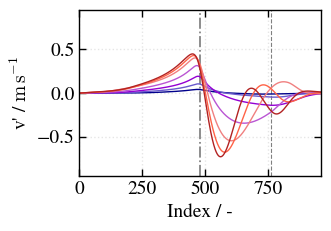

In [24]:
fig, (ax0) = plt.subplots(1,1,figsize=(3.5,2.5))
x = int(ds.nx/2)
xs = 760
ax0.axvline(x,c='grey',ls='-.',lw=1.25)
ax0.axvline(xs,c='grey',ls='dashed')

for i,ds in enumerate(ds_list):
    ax0.plot(ds['v'][6,5,y,:].values, color=COLS[i],lw=1)


ax0.grid(visible=True)
ax0.set_ylabel(r"v' / $\mathrm{m} \, \mathrm{s}^{-1}$")
ax0.set_xlabel("Index / -")
ax0.set_ylim((-0.95,0.95))
ax0.set_xlim((0,960))

fig_title = 'MWs-zprofiles-vprime.png'
fig.tight_layout()
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=300, bbox_inches='tight')

In [28]:
ds

<xarray.Dataset>
Dimensions:    (t: 7, z: 701, y: 48, x: 960)
Coordinates:
    xcr        (y, x) float32 -1.199e+03 -1.196e+03 ... 1.196e+03 1.199e+03
    zcr        (t, z, y, x) float32 0.0004991 0.0004991 0.0005006 ... 35.0 35.0
    ycr        (y, x) float32 -2.35e+03 -2.35e+03 ... 2.35e+03 2.35e+03
    zs         (y, x) float32 0.0004991 0.0004991 ... 0.0004991 0.0004991
    zh         (y, x) float32 35.0 35.0 35.0 35.0 35.0 ... 35.0 35.0 35.0 35.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/20)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 1.01e+05 1.01e+05 ... 2.896e+04 2.896e+04
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 0.0004991 2.986e-07 ... -2.986e-07 0.0004991
    pref00     float64 1.01e+05
    pprime     (t, z, y, x) float32 ...
Attributes: (12/54)
    nt:           5760
    nplot:        960
    nstore:       100000
    nlid:         1000000
    dt00:         75.0
    dx00:         2500.0
    ...           ...
    grav:         9.80616
    cap:          0.2857142857142857
    capi:         3.5
    capp:         0.7142857142857143
    cappi:        1.4
    compri:       10.659520642663725

189
9.999904099540155e-05
9.999904099540155e-05
9.999904099540155e-05
9.999904099540155e-05
9.999904099540155e-05
9.999904099540155e-05
9.999904099540155e-05


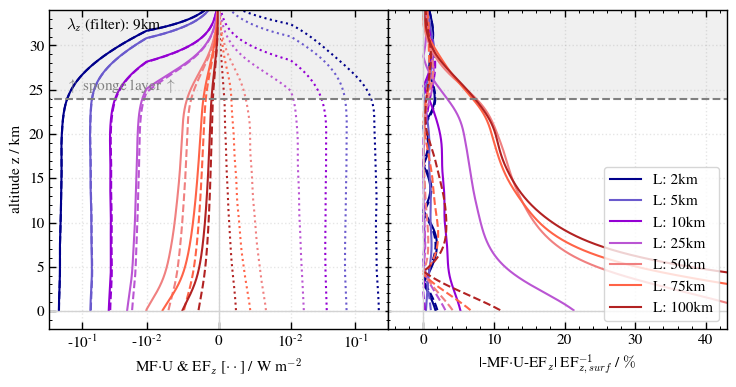

In [64]:
gskw = {'wspace':0}
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(7.5,4),sharey=True, gridspec_kw=gskw)

# --- SET TIME, Y AND VERTICAL AEQUIDISTANT GRID --- #
# x=480+53 # t=4 -> 400km (dx=7500m) // 
# x=480 # t=3
# x_range = 20 # -> mean over width of 300km
t=5 # t=3 -> 36h
COLS=['darkblue','slateblue','darkviolet', 'mediumorchid', 'lightcoral','tomato', 'firebrick', 'black']
# COLS=['black', 'blueviolet', 'goldenrod', 'firebrick', 'forestgreen', 'steelblue', 'olive', 'peru']
ZLIM = [-2,34]

# --- INDEXES FOR VERTICAL AND HORIZONTAL AVERAGE --- #
wind_f = 15 # m/s
# nx_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dx00)+1
# nz_avg = int(2*np.pi*(ds['ue'][0,0,0,0]-50/3.6)/ds.bv/ds.dz00)+1
# nx_avg = int(2*np.pi*wind_f/ds.bv/ds.dx00)+1
nz_avg = int(2*np.pi*wind_f/ds.bv/ds.dz00)+1
# nz_avg = 40 # *0.25km -> 10km
print(nz_avg)

i=0
for ds in ds_list:
    y=int(ds.ny/2)
    z = np.linspace(0,ds['zcr'][t,-1,y,0].values,int(ds.nz)) # ds['dx']=200
    
    # - Coriolis and dthdz for angular momentum flux calculation - #
    f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
    print(f)
    
    z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
    the = ds['the'][t,:,y,:]
    the = the.assign_coords(z_coord = ("z",z_coord))
    dthdz = the.differentiate("z_coord")
    
    # --------- Calculate fluxes -------------------- # 
    uw   = ds['w'][t,:,y,:] * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:])
    vw   = ds['w'][t,:,y,:] * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:])
    mfx  = ds['rh0'][t,:,y,:] * uw # h9=h3*h6
    mfx_ang = ds['rh0'][t,:,y,:] * (uw - f * (ds['v'][t,:,y,:]-ds['ve'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz) ###########
    mfy  = ds['rh0'][t,:,y,:] * vw
    mfy_ang = ds['rh0'][t,:,y,:] * (vw - f * (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['th'][t,:,y,:] / dthdz)
    MF_U = mfx * ds['u'][t,:,y,:] - mfy * ds['v'][t,:,y,:] # = -EFz
    MF_U_ang = mfx_ang * ds['u'][t,:,y,:] - mfy_ang * ds['v'][t,:,y,:]
    
    efx = (ds['u'][t,:,y,:]-ds['ue'][t,:,y,:]) * ds['pprime'][t,:,y,:] # h14, EFx1
    efz = ds['w'][t,:,y,:] * ds['pprime'][t,:,y,:] # h13, EFz1

    # -- TEMPERATURE CALCULATION -- #                             
    thloc = ds['the'][t,:,y,:] + ds['th'][t,:,y,:] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,:,y,:]*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T_env
    tloc = thloc*(ds['pr0'][t,:,y,:]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte

    ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'][t,:,y,:] #  potential energy density
    # --------- Calculate fluxes -------------------- # 
    
    # --- INTERPOLATE TO AEQUIDISTANT GRID FOR FILTER ----- #
    rho  = subroutines.interp_elev_to_z(ds['rh0'][t,:,y,:],ds.zcr[t,:,y,:],z)
    u    = subroutines.interp_elev_to_z(ds['u'][t,:,y,:],ds.zcr[t,:,y,:],z)
    v    = subroutines.interp_elev_to_z(ds['v'][t,:,y,:],ds.zcr[t,:,y,:],z)
    uw   = subroutines.interp_elev_to_z(uw,ds.zcr[t,:,y,:],z)
    vw   = subroutines.interp_elev_to_z(vw,ds.zcr[t,:,y,:],z)
    mfx  = subroutines.interp_elev_to_z(mfx,ds.zcr[t,:,y,:],z)
    mfx_ang  = subroutines.interp_elev_to_z(mfx_ang,ds.zcr[t,:,y,:],z)
    mfy  = subroutines.interp_elev_to_z(mfy,ds.zcr[t,:,y,:],z)
    efx  = subroutines.interp_elev_to_z(efx,ds.zcr[t,:,y,:],z)
    efz  = subroutines.interp_elev_to_z(efz,ds.zcr[t,:,y,:],z)
    ep   = subroutines.interp_elev_to_z(ep,ds.zcr[t,:,y,:],z)
    MF_U = subroutines.interp_elev_to_z(MF_U,ds.zcr[t,:,y,:],z)
    MF_U_ang = subroutines.interp_elev_to_z(MF_U_ang,ds.zcr[t,:,y,:],z)
    
    # --- FFT OR RUNNING MEAN FILTER ------ #
    mm = 1
    # --- 2D filter --- # 
    # uw=filter_2D(uw,nx_avg,nz_avg,mode=mm)
    # mfx=filter_2D(mfx,nx_avg,nz_avg,mode=mm)
    # ep=filter_2D(ep,nx_avg,nz_avg,mode=mm)
    
    # --- 1D filter --- #
    rho = subroutines.filter_1Dz(rho,nz_avg,mode=mm)
    uw  = subroutines.filter_1Dz(uw,nz_avg,mode=mm)
    vw  = subroutines.filter_1Dz(vw,nz_avg,mode=mm)
    mfx = subroutines.filter_1Dz(mfx,nz_avg,mode=mm)
    mfx_ang = subroutines.filter_1Dz(mfx_ang,nz_avg,mode=mm)
    mfy = subroutines.filter_1Dz(mfy,nz_avg,mode=mm)
    ep  = subroutines.filter_1Dz(ep,nz_avg,mode=mm)
    efx = subroutines.filter_1Dz(efx,nz_avg,mode=mm)
    efz = subroutines.filter_1Dz(efz,nz_avg,mode=mm)
    MF_U = subroutines.filter_1Dz(MF_U,nz_avg,mode=mm)
    MF_U_ang = subroutines.filter_1Dz(MF_U_ang,nz_avg,mode=mm)
    
    # - Calc fluxes after interpolations and averaging/filtering - #
    # mfx2 = rho*uw
    # mfy2 = rho*vw
    # MF_U2 = mfx*u + mfy*v
    
    # --- Horizontal average / horizontal integration of fluxes --- #
    if ds.irelx: # sponge layer left/right active 
        n_sponge=int(ds.dxabL/ds.dx00)
    else: # cyclic boundaries
        n_sponge=0
    
    # -> horizontal mean
    uw_m = uw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    vw_m = vw[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfx_m = mfx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfx_ang_m = mfx_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    mfy_m = mfy[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    ep_m = ep[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efx_m = efx[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    efz_m = efz[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_m = MF_U[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    MF_U_ang_m = MF_U_ang[:,n_sponge:ds.nx-n_sponge].mean(axis=1)
    
    delta_ep = (-efz_m-MF_U_m)/efz_m[0]*100
    delta_ep_ang = (-efz_m-MF_U_ang_m)/efz_m[0]*100
    # delta_ep = subroutines.filter_1Dz(delta_ep,nz_avg,mode=0)

    def vertical_filter_for_ep_diff(data):
        ## REPLACE NANs AND PAD ##
        data = data.ffill(dim='z').bfill(dim='z')
        data = data.pad(z=nz_avg, mode="edge")
        # data = data.pad(x=nx_avg, mode="edge")

        ## FFT ##
        data=data.drop(['z'])
        da_fft = xrft.fft(data) # Fourier Transform w/ numpy.fft-like behavior   
        # da_fft = xrft.dft(data, true_phase=True, true_amplitude=True)

        ## GAUSSIAN RESPONSE FUNCTION ##
        response_func_z = np.exp(-da_fft.freq_z**2 * nz_avg**2)
        da_fft_low = da_fft * response_func_z

        ## INVERSE FFT ##
        data_filtered = xrft.ifft(da_fft_low)[nz_avg:ds.nz+nz_avg]
        return data_filtered
    
    delta_ep = vertical_filter_for_ep_diff(delta_ep)
    delta_ep_ang = vertical_filter_for_ep_diff(delta_ep_ang)
    
    # -- VISUALIZATION -- #
    lw=1.5
    ax0.plot(efz_m[2:], z[2:], lw=lw, label=labels[i], ls='dotted', color=COLS[i])
    ax0.plot(MF_U_m[2:], z[2:], lw=lw, color=COLS[i])
    ax0.plot(MF_U_ang_m[2:], z[2:], lw=lw, color=COLS[i], ls='dashed')
    # ax0.plot(MF_U_m_2[2:], z[2:], lw=lw, color=COLS[i], ls='dotted')
    ax1.plot(abs(delta_ep[2:]), z[2:], lw=lw, label=labels[i], color=COLS[i]) # subtract absolute values!!!
    ax1.plot(abs(delta_ep_ang[2:]), z[2:], lw=lw, ls='dashed', color=COLS[i])
    
    i+=1
    
# -- FORMAT AXES -- #
ax0.set_xlabel(r"MF$\cdot$U & EF$_z$ [$\cdot \cdot$] / W m$^{-2}$")
ax1.set_xlabel(r"|-MF$\cdot$U-EF$_z$| EF$_{z,surf}^{-1}$ / $\%$")

ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())

ax0.tick_params(axis="y", which='both', right=False)
ax1.tick_params(axis="y", which='both', direction="inout", right=False)

# - SPONGE LAYER - #
lw_sponge = 1.5
hsponge = 24
ax0.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')
ax1.hlines(y=hsponge, xmin=-20, xmax=200, lw=lw_sponge,ls='--',color='grey')

sponge_label = r'$\uparrow$ sponge layer $\uparrow$'
ax0.text(0.05, 0.75, sponge_label, transform=ax0.transAxes, color='grey')

c3 = 'lightgrey'
htop = 34
alpha_sponge = 0.33
# axes[i,j].axhline(y=48, lw=1.5,ls='--',color='grey')
ax0.fill_between(ax0.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)
ax1.fill_between(ax1.get_xlim(), [hsponge,hsponge], [htop,htop], facecolor=c3, alpha=alpha_sponge)

symb_ax = '-'
col_ax = 'lightgrey'
lw_ax = 1
ax0.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)
ax1.hlines(y=0, xmin=-20, xmax=200, lw=lw_ax,ls=symb_ax,color=col_ax)

ax0.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)
ax1.vlines(x=0, ymin=-10, ymax=100, lw=lw_ax,ls=symb_ax,color=col_ax)

# --- Labels and legend --- #
ax1.legend(loc='lower right') # 'upper left'
# ax5.axis('off')

ax0.set_ylim(ZLIM)
ax0.set_ylabel(r'altitude z / km')

# --- Limits and Sci format --- #
ax0.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))

# ax1.set_xlim([-0.27,0.27]) # EFz
ax0.set_xlim([-0.32,0.32]) # EFz
ax0.set_xscale('symlog', linthresh=0.01) # 0.01
ax1.set_xlim([-5,43]) # Delta

ax0.grid(visible=True)
ax1.grid(visible=True)

# --- Text --- #
# ax0.text(0.1, 0.9, 'Transient topo', transform=ax5.transAxes)

time_label = 'T' + str(t*12) + 'h'

fig_title = 'MWs-zprofiles_EPflux.png'

# ax0.text(0.05, 0.94, time_label, transform=ax0.transAxes, weight='bold')

filter_label = '$\lambda_z$ (filter): ' + str(int(nz_avg*ds.dz00/1000)) + 'km'
ax0.text(0.05, 0.94, filter_label, transform=ax0.transAxes)

# --- Save figure --- #
# fig.suptitle(title_label)
fig.tight_layout()
fig.savefig('../figures/' + fig_title, facecolor='w', edgecolor='w',
                format='png', dpi=450, bbox_inches='tight')

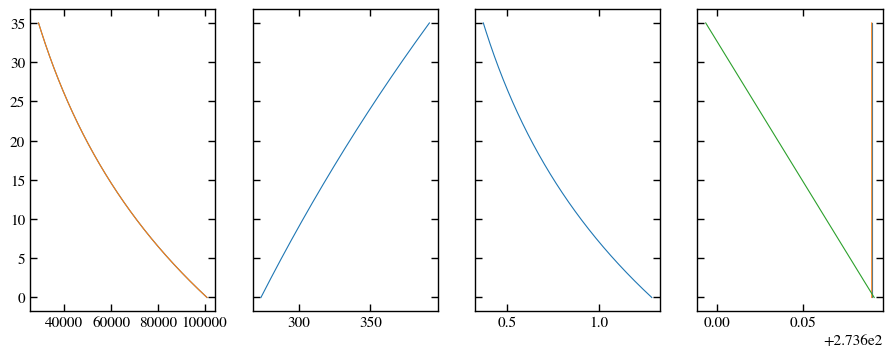

In [63]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4,figsize=(11,4),sharey=True)
ax0.plot(ds['pr0'][0,:,0,0],ds.zcr[0,:,0,0])
ax0.plot(ds['ppe'][0,:,0,0],ds.zcr[0,:,0,0])
ax1.plot(ds['the'][0,:,0,0],ds.zcr[0,:,0,0])
ax2.plot(ds['rhe'][0,:,0,0],ds.zcr[0,:,0,0])
ax3.plot(ds['tr0'][0,:,0,0],ds.zcr[0,:,0,0])
ax3.plot(ds['pr0'][0,:,0,0]/(ds.rg*ds['rhe'][0,:,0,0]),ds.zcr[0,:,0,0])
ax3.plot(ds['the'][0,:,0,0]*(ds['pr0'][0,:,0,0]/ds['pref00'])**0.286,ds.zcr[0,:,0,0])